In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from PIL import Image

from sklearn import metrics

import cv2
import os

from glob import glob

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')


In [3]:
from zipfile import ZipFile
data_path = 'fer2013.zip'

with ZipFile(data_path, 'r') as zip:
    zip.extractall()
print('The data set has been extracted.')


The data set has been extracted.


In [4]:
path = 'train'
classes = os.listdir('train')
classes

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']

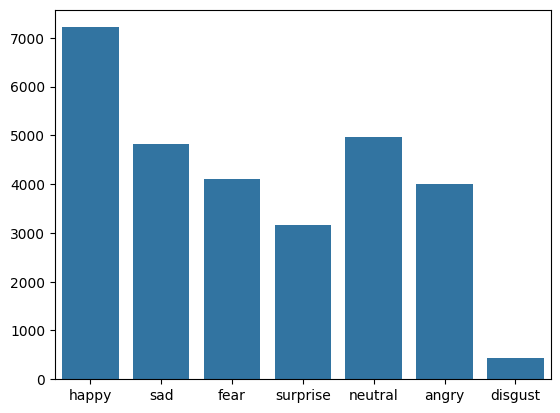

In [5]:
count = []
for cat in classes:
    count.append(len(os.listdir(f'{path}/{cat}')))

sb.barplot(x=classes, y=count)
plt.show()

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
		'train',
		target_size=(48,48),
		batch_size=64,
		color_mode="grayscale",
		class_mode='categorical')

val_gen = val_datagen.flow_from_directory(
		'test',
		target_size=(48,48),
		batch_size=64,
		color_mode="grayscale",
		class_mode='categorical')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
emotions = list(train_gen.class_indices.keys())


In [8]:
model = keras.models.Sequential([
									layers.Conv2D(32,(3,3),activation='relu',input_shape=(48, 48, 1)),
									layers.Conv2D(64,(3,3),activation='relu'),
									layers.MaxPooling2D(2,2),


									layers.Flatten(),
									layers.Dense(64,activation='relu'),
									layers.BatchNormalization(),
									layers.Dense(32,activation='relu'),
									layers.Dropout(0.3),
									layers.BatchNormalization(),
									layers.Dense(7, activation='softmax')
])


In [9]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics=['accuracy']
)


In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\nValidation accuracy has reached up to 90%, so stopping further training.')
            self.model.stop_training = True

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)


In [11]:
history = model.fit(train_gen,
					validation_data = val_gen,
					epochs = 1,
					verbose = 1,
					callbacks = [es, lr, myCallback()])


449/449 [==============================] - 89s 196ms/step - loss: 1.7610 - accuracy: 0.3385 - val_loss: 1.6856 - val_accuracy: 0.3523 - lr: 0.0010


In [12]:
def plot_image(img, emoj):
	wmin = 256
	hmin = 256

	emoj = cv2.resize(emoj, (wmin, hmin))
	img = cv2.resize(img, (wmin, hmin))
	cv2.imshow('Images', cv2.hconcat([img, emoj]))


In [13]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

img = cv2.imread('harshal.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray)

for (x, y, w, h) in faces:
	gray = cv2.resize(gray[x:x+w-10,y:y+h+10], (48,48))
	gray = np.expand_dims(gray, axis=-1)
	gray = np.expand_dims(gray, axis=0)

	pred = model.predict(gray)
	idx = pred.argmax(axis=-1)[0]

	emoj = cv2.imread(f'emojis/{classes[idx]}.jpg')

	plot_image(img, emoj)

	if cv2.waitKey(1) & 0xFF == ord('q'):
		break

cv2.destroyAllWindows()


1/1 [==============================] - 0s 72ms/step


In [14]:
classes[idx]

'fear'